100.1%

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


113.5%

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


100.4%

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz


180.4%/home/konrad/miniconda3/envs/sanity_checks_pytorch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:335: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed).view(length, num_rows, num_cols)


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


/home/konrad/miniconda3/envs/sanity_checks_pytorch/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


true: 8, pred: 8


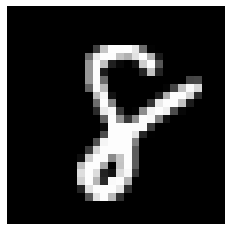

true: 9, pred: 9


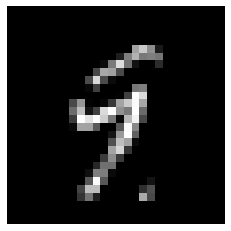

true: 6, pred: 6


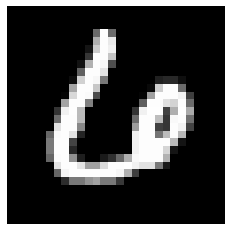

true: 4, pred: 4


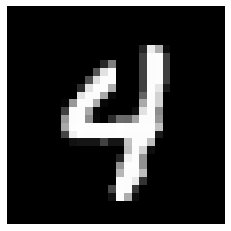

true: 1, pred: 1


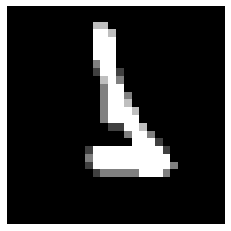

true: 0, pred: 0


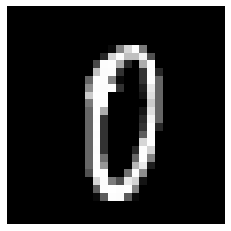

true: 4, pred: 4


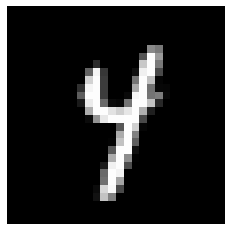

true: 4, pred: 4


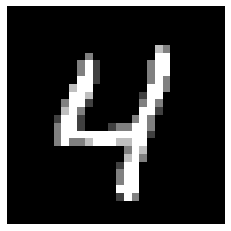

true: 8, pred: 8


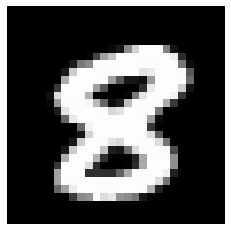

true: 8, pred: 8


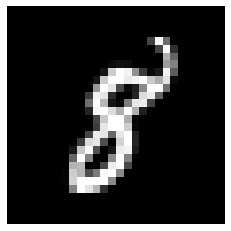

In [4]:
from torchvision import datasets, transforms
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from src import util

model = torch.load('models/cnn_mnist.pt', map_location=torch.device('cpu'))
model.eval()

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset = datasets.MNIST('data', train=False, transform=transform, download=True)
dataset_subset = torch.utils.data.Subset(dataset, np.random.choice(len(dataset), 10, replace=False))
test_loader = torch.utils.data.DataLoader(dataset_subset, batch_size=1, shuffle=False)

single_instance = torch.utils.data.Subset(dataset, np.random.choice(len(dataset), 2, replace=False))
single_loader = torch.utils.data.DataLoader(single_instance, batch_size=1, shuffle=False)

for image, label in test_loader:
    pred = model(image).argmax(axis=1)
    npimg = np.squeeze(np.squeeze(image.numpy()))
    plt.imshow(npimg, cmap='gray')
    print(f'true: {label[0]}, pred: {pred[0]}')
    plt.axis('off')
    plt.show()

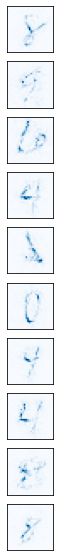

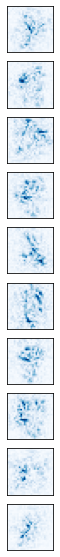

In [39]:
# visualize integrated gradients for mnist cnn

import torchvision
from captum.attr import IntegratedGradients, Saliency, InputXGradient, GuidedBackprop, GuidedGradCam
from captum.attr import visualization as viz

def attribute_image_features(algorithm, input, label, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input, target=label, **kwargs)
    
    return tensor_attributions


# Given a NN model, ...
def visualize_saliency_method(model, saliency_class, saliency_kwargs, image, label, plt_fig_axis):
    image.requires_grad = True
    attrs = attribute_image_features(
            # TODO move saliency_class to get_kwargs
            saliency_class(model), # get an instance of the saliency model class
            image,
            label=label,
            **saliency_kwargs
#             baselines=image * 0,
    )
    attrs = np.transpose(attrs.squeeze(0).cpu().detach().numpy(), (1,2,0))
#     print('Approximation delta: ', abs(delta))
    original_image = np.transpose(image.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    return viz.visualize_image_attr(attrs, original_image, method="heat_map",sign="absolute_value",
                          plt_fig_axis=plt_fig_axis, cmap="Blues", show_colorbar=False,
                          use_pyplot=False)


ig = IntegratedGradients
fig, axs = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(10, 10))
for (image, label), row in zip(test_loader, range(len(test_loader))):
    ig_kwargs = {'baselines': image * 0} # stuff specific to integrated gradients
    fig, _ = visualize_saliency_method(model, ig, ig_kwargs, image, label, (fig, axs[row]))
plt.show(fig)

sal = Saliency
fig, axs = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(10, 10))
for (image, label), row in zip(test_loader, range(len(test_loader))):
    sal_kwargs = {} # stuff specific to gradients (saliency)
    fig, _ = visualize_saliency_method(model, sal, sal_kwargs, image, label, (fig, axs[row]))
plt.show(fig)

In [33]:
def get_kwargs(saliency_method, image=None):
    if saliency_method == IntegratedGradients:
        if image is None:
            raise Exception("Image needs to be specified for saliency method \"Integrated Gradients\"")
        return {'baselines': image * 0}
    elif saliency_method == Saliency:
        return {}
    elif saliency_method == InputXGradient:
        return {}
    elif saliency_method == GuidedBackprop:
        return {}
    elif saliency_method == GuidedGradCam:
        return {}
    else:
        raise Exception("Saliency method not supported :(")

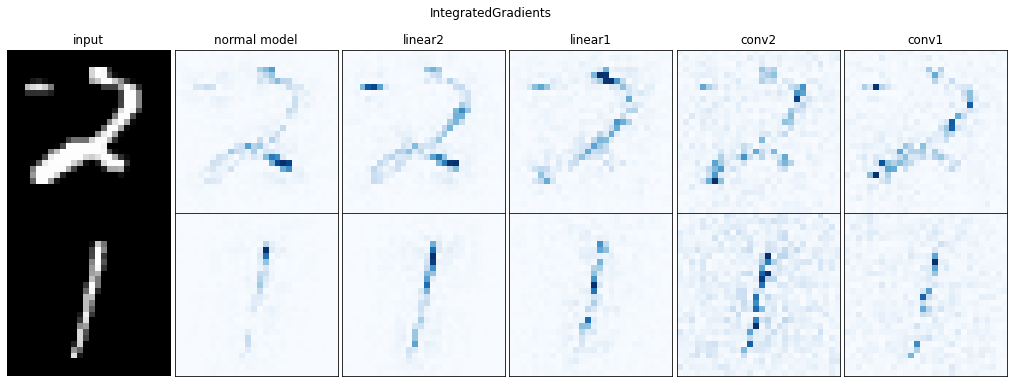

In [40]:
def visualize_cascading_randomization(model, module_paths, examples, saliency_method):
    model_copy = copy.deepcopy(model)
    
    # make plt plot
    nrows = len(examples)
    ncols = len(module_paths) + 2
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
    fig.subplots_adjust(hspace=0, wspace=0)
    
    # show input image at the very left
    for (image, _), row in zip(examples, range(nrows)):
        npimg = np.squeeze(np.squeeze(image.numpy()))
        axs[row, 0].imshow(npimg, cmap='gray')
        axs[row, 0].axis('off')
    
    # show visualizations before scrambling the model
    for (image, label), row in zip(examples, range(nrows)):
        pred = model_copy(image).argmax(axis=1).item()
        sal_kwargs = get_kwargs(saliency_method, image)
        fig, _ = visualize_saliency_method(model_copy, saliency_method, sal_kwargs, image, label, (fig, axs[row, 1]))

    # cascading randomization and visualization of IG
    # start with 1 because 0th column is unscrambled model
    for path, col in zip(module_paths, range(2, ncols)):
        util.rand_layers(model_copy, [path])
        for (image, label), row in zip(examples, range(nrows)):
            pred = model_copy(image).argmax(axis=1).item()
            sal_kwargs = get_kwargs(saliency_method, image)
            fig, _ = visualize_saliency_method(model_copy, saliency_method, sal_kwargs, image, label, (fig, axs[row, col]))
    
    # set titles for each column
    col_titles = ['input', 'normal model'] + [x for x in map((lambda x: '_'.join(x)), module_paths)]
    for ax, col in zip(axs[0], col_titles):
        ax.set_title(col)
    
    # set title for the whole thing
    fig.suptitle(saliency_method.__name__)


module_paths = [['linear2'], ['linear1'], ['conv2'], ['conv1']]
visualize_cascading_randomization(model, module_paths, single_loader, IntegratedGradients)

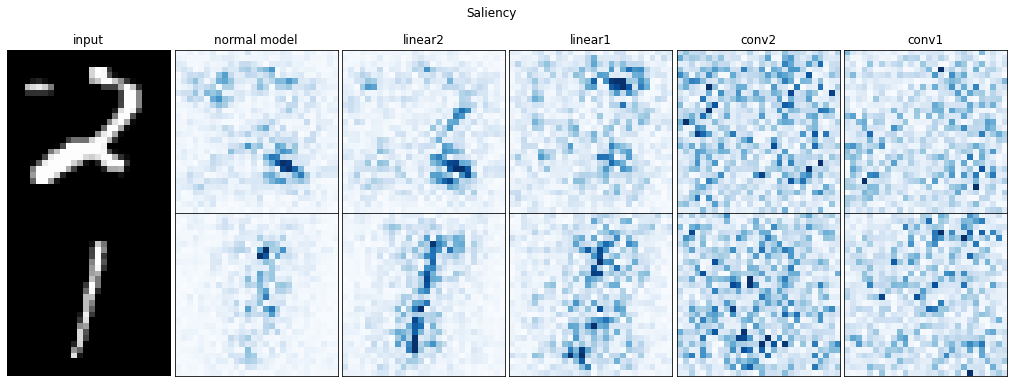

In [41]:
visualize_cascading_randomization(model, module_paths, single_loader, Saliency)

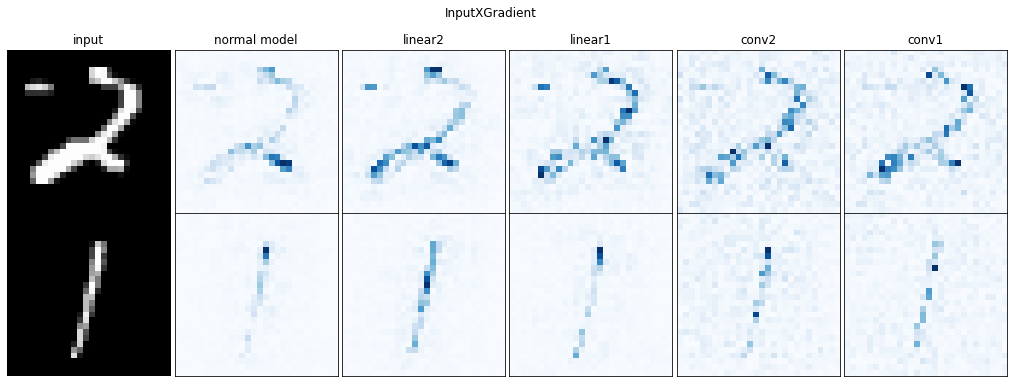

In [42]:
visualize_cascading_randomization(model, module_paths, single_loader, InputXGradient)